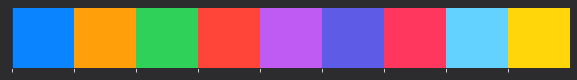

In [19]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cycler import cycler
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorboard as tb
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.data import Dataset

%matplotlib inline

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]
raw_darks=[
    (44, 44, 46)
]
raw_lights=[
    (229, 229, 234)
]
miscellaneous={
    'blue':'#0f71d4',
    'green':'#14b827',
    'red':'#cf0c0c'
}

dark_palette=np.array(raw_dark_palette)/255
darks=np.array(raw_darks)/255
lights=np.array(raw_lights)/255

#rcparams
dark_color=darks[-1]
light_color=lights[-1]

mpl.rcParams['axes.prop_cycle']=cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']=dark_color
mpl.rcParams['figure.edgecolor']=dark_color
mpl.rcParams['axes.facecolor']=dark_color
mpl.rcParams['text.color']=light_color
mpl.rcParams['axes.labelcolor']=light_color
mpl.rcParams['axes.edgecolor']=dark_color
mpl.rcParams['xtick.color']=light_color
mpl.rcParams['ytick.color']=light_color
mpl.rcParams['figure.dpi']=80
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

sns.palplot(dark_palette)

In [36]:
train=pd.read_csv('data/train.csv',index_col=[0])
test=pd.read_csv('data/test.csv',index_col=[0])
train['target']=train['target'].str.slice(start=6).astype(int)-1
smote_train=pd.read_csv('data/smote_train.csv')
train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,1
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,13,2,0,0
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [37]:
train,val=train_test_split(train,test_size=0.2)
sm_train,sm_val=train_test_split(smote_train,test_size=0.2)

In [38]:
train_target=train.pop('target')
val_target=val.pop('target')
train=Dataset.from_tensor_slices((train.values,train_target.values))
val=Dataset.from_tensor_slices((val.values,val_target.values))

In [40]:
sm_train_target=sm_train.pop('target')
sm_val_target=sm_val.pop('target')
sm_train=Dataset.from_tensor_slices((sm_train.values,sm_train_target.values))
sm_val=Dataset.from_tensor_slices((sm_val.values,sm_val_target.values))

In [5]:
BATCH_SIZE=32
BUFFER_SIZE=10000
EPOCHS=100

In [41]:
train=train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)
val=val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

In [42]:
sm_train=sm_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)
sm_val=sm_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

In [44]:
def create_model():
    model=Sequential([
        Dense(256,activation='relu'),
        Dense(256,activation='relu'),
        Dropout(0.15),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        BatchNormalization(),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dropout(0.15),
        Dense(32,activation='relu'),
        Dense(32,activation='relu'),
        BatchNormalization(),
        Dense(16,activation='relu'),
        Dense(16,activation='relu'),
        Dropout(0.15),
        Dense(4,activation='softmax'),
    ])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy')
    return model

In [45]:
model_checkpoint=ModelCheckpoint('models/model2.h5',save_best_only=True,monitor='val_loss')
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=3)

In [21]:
model1=create_model()
history=model1.fit(sm_train,validation_data=sm_val,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[model_checkpoint,early_stopping,reduce_lr])

Epoch 1/100
5750/5750 [==============================] - 22s 4ms/step - loss: 1.3300 - val_loss: 1.2858
Epoch 2/100
5750/5750 [==============================] - 23s 4ms/step - loss: 1.2808 - val_loss: 1.2781
Epoch 3/100
5750/5750 [==============================] - 21s 4ms/step - loss: 1.2714 - val_loss: 1.2721
Epoch 4/100
5750/5750 [==============================] - 21s 4ms/step - loss: 1.2645 - val_loss: 1.2669
Epoch 5/100
5750/5750 [==============================] - 21s 4ms/step - loss: 1.2587 - val_loss: 1.2627
Epoch 6/100
5750/5750 [==============================] - 21s 4ms/step - loss: 1.2516 - val_loss: 1.2591
Epoch 7/100
5750/5750 [==============================] - 21s 4ms/step - loss: 1.2451 - val_loss: 1.2567
Epoch 8/100
5750/5750 [==============================] - 21s 4ms/step - loss: 1.2401 - val_loss: 1.2520
Epoch 9/100
5750/5750 [==============================] - 22s 4ms/step - loss: 1.2361 - val_loss: 1.2514
Epoch 10/100
5750/5750 [==============================] - 21s 4m

In [24]:
model1_pred=model1.predict(test)

ValueError: in user code:

    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    F:\anacondapython\envs\tf\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 49 but received input with shape (None, 50)


In [11]:
print(model1_pred[:5])

[[0.09799209 0.64253616 0.15055744 0.10891426]
 [0.0928166  0.65439385 0.15636568 0.09642395]
 [0.08271524 0.62466645 0.1609107  0.13170764]
 [0.08673698 0.4556475  0.3599584  0.09765709]
 [0.07889219 0.5478458  0.24141023 0.1318518 ]]


In [12]:
sub=pd.read_csv('data/sample_submission.csv')
sub.iloc[:,1:]=model1_pred
sub.to_csv('submissions/sub9.csv',index=False)